### Obtención del grafo

In [2]:
import osmnx as ox

# Obtener el grafo y lo proyectamos para tener coordenadas planas
# G = ox.project_graph(ox.graph_from_place("Alcalá de Henares, Madrid, Spain", network_type='drive'))
G = ox.project_graph(ox.graph_from_place("Alcalá de Henares, Madrid, Spain", network_type='drive'))
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

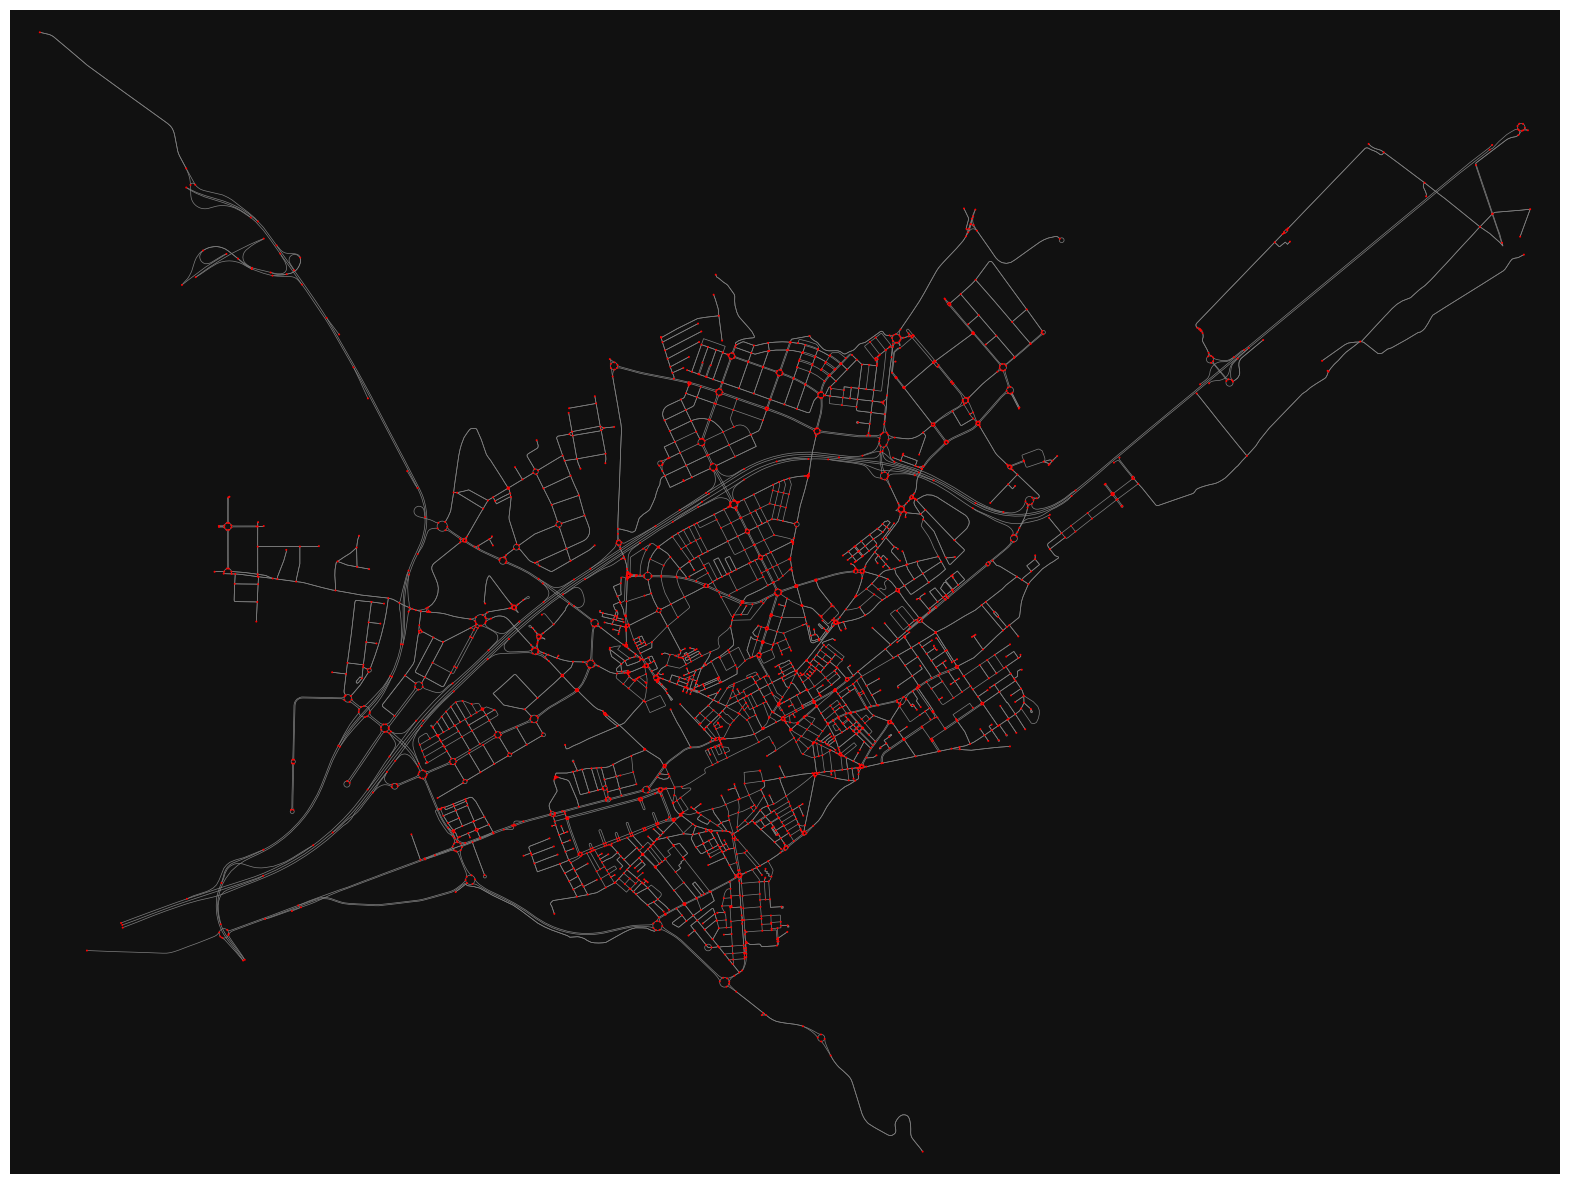

In [3]:
# Customized plot
fig, ax = ox.plot_graph(
    G,
    node_color='r',          # red nodes
    node_size=2,           # larger nodes
    edge_color='gray',      # gray edges
    edge_linewidth=0.5,     # thinner edges
    show=True,              # display the plot
    figsize=(20,20)         # custom figure size
)

## Segmentación de aristas largas

In [4]:
import osmnx as ox
import networkx as nx
import numpy as np
from shapely.geometry import Point

def segment_long_edges(G, max_length=100):
    """Segmenta aristas largas en múltiples segmentos"""
    new_edges = []
    nodes_to_add = {}
    edges_to_remove = []
    
    node_counter = max(G.nodes()) + 1
    
    for u, v, data in G.edges(data=True):
        length = data.get('length', 0)
        
        if length > max_length:
            # Calcular número de segmentos necesarios
            num_segments = int(np.ceil(length / max_length))
            segment_length = length / num_segments
            
            # Obtener geometría de la arista
            if 'geometry' in data:
                # Usar geometría existente
                line = data['geometry']
                coords = list(line.coords)
            else:
                # Crear línea recta entre nodos
                x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
                x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
                coords = [(x1, y1), (x2, y2)]
            
            # Crear nodos intermedios
            prev_node = u
            for i in range(1, num_segments):
                # Interpolar posición
                t = i / num_segments
                if len(coords) == 2:  # Línea recta
                    x = coords[0][0] + t * (coords[1][0] - coords[0][0])
                    y = coords[0][1] + t * (coords[1][1] - coords[0][1])
                else:  # Geometría compleja
                    point = line.interpolate(t, normalized=True)
                    x, y = point.x, point.y
                
                new_node = node_counter
                nodes_to_add[new_node] = {'x': x, 'y': y}
                
                # Crear arista desde nodo anterior al nuevo
                edge_data = data.copy()
                edge_data['length'] = segment_length
                edge_data['travel_time'] = edge_data['length'] / (edge_data['speed_kph'] / 3.6)  # Convertir velocidad de km/h a m/s
                new_edges.append((prev_node, new_node, edge_data))
                
                prev_node = new_node
                node_counter += 1
            
            # Última arista hasta el nodo final
            edge_data = data.copy()
            edge_data['length'] = segment_length
            edge_data['travel_time'] = edge_data['length'] / (edge_data['speed_kph'] / 3.6)  # Convertir velocidad de km/h a m/s

            new_edges.append((prev_node, v, edge_data))
            
            edges_to_remove.append((u, v))
    
    # Aplicar cambios al grafo
    G.add_nodes_from(nodes_to_add.items())
    G.add_edges_from(new_edges)
    G.remove_edges_from(edges_to_remove)
    
    return G

# Usar la función
G_segmented = segment_long_edges(G.copy(), max_length=100)  # Segmentos de 50m máximo

print(f"Nodos originales: {len(G.nodes())}")
print(f"Nodos segmentados: {len(G_segmented.nodes())}")
print(f"Aristas originales: {len(G.edges())}")
print(f"Aristas segmentadas: {len(G_segmented.edges())}")

Nodos originales: 3070
Nodos segmentados: 6793
Aristas originales: 6012
Aristas segmentadas: 9735


## Selección de la componente conexa más grande

In [5]:

df_componentes = nx.strongly_connected_components(G_segmented)  # Hallar la componente fuertemente conexa más grande 
largest_component = max(df_componentes, key=len)
G_segmented = G_segmented.subgraph(largest_component)

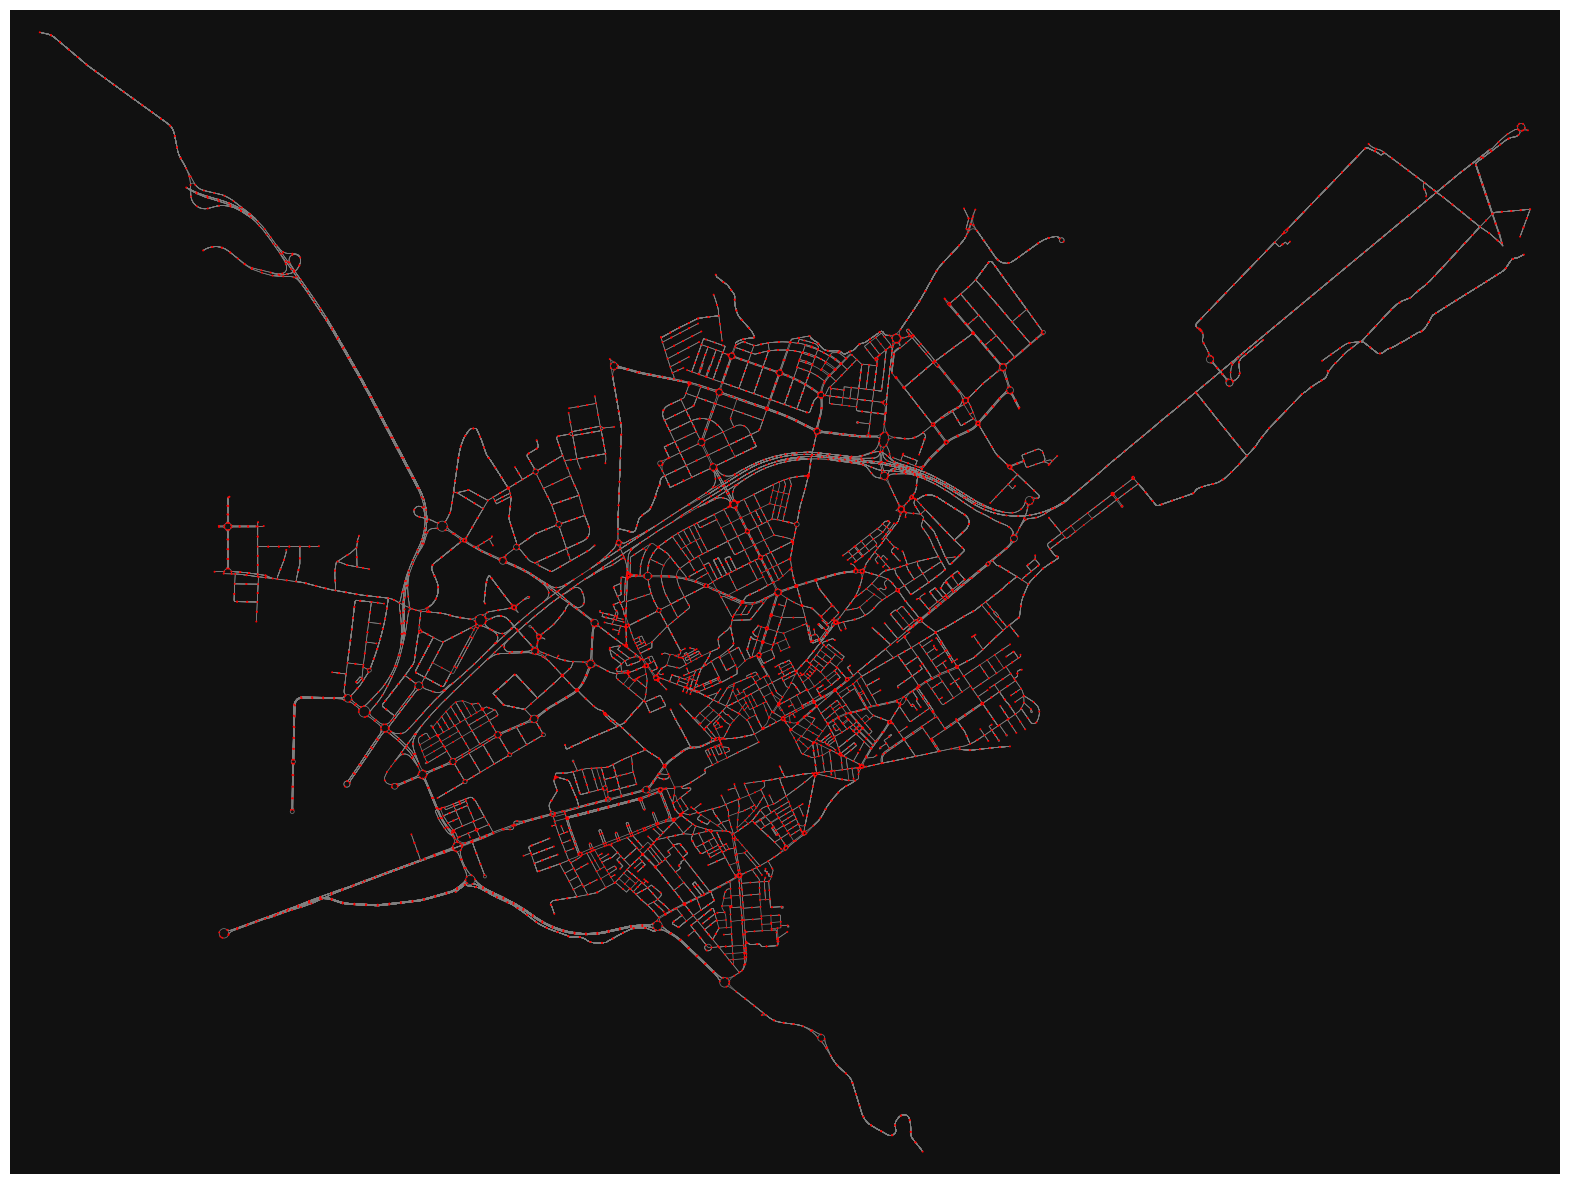

In [6]:
# Customized plot
fig, ax = ox.plot_graph(
    G_segmented,
    node_color='r',          # red nodes
    node_size=2,           # larger nodes
    edge_color='gray',      # gray edges
    edge_linewidth=0.5,     # thinner edges
    show=True,              # display the plot
    figsize=(20,20)         # custom figure size
)

## Graficado de ruta entre dos puntos

Funcionalidad auxiliar para depurar el script.

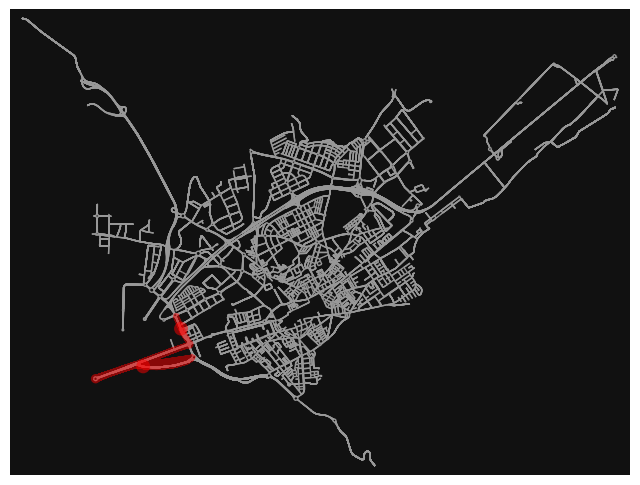

In [7]:
# Get random or specific nodes
origin_node = 12817858702
destination_node = 12817858628

# Calculate the shortest path
route = nx.shortest_path(G_segmented, origin_node, destination_node, weight='length')

# Plot the route
fig, ax = ox.plot_graph_route(G_segmented, route, 
                             route_color='r',
                             route_linewidth=4,
                             node_size=0)

## Normalización de nodos

Los nodos en principio aparecen en coordenadas cartesianas. En este apartado trataremos de normalizarlas a coordenadas entre [0,1].

In [8]:
x_coords = [G_segmented.nodes[node_id]['x'] for node_id in G_segmented.nodes()]
y_coords = [G_segmented.nodes[node_id]['y'] for node_id in G_segmented.nodes()]

min_x, max_x = min(x_coords), max(x_coords)
min_y, max_y = min(y_coords), max(y_coords)

# Using this coords we need to normalize the coordinates
format_coords = lambda x, y: ((x - min_x) / (max_x - min_x), (y - min_y) / (max_y - min_y))
coord_list = [ (node_id, format_coords(G_segmented.nodes[node_id]['x'], G_segmented.nodes[node_id]['y'])) for node_id in G_segmented.nodes() ]

In [9]:
import pandas as pd

cood_list = [{
    'id': node_id,
    'x': coord[0],
    'y': coord[1]
} for node_id, coord in coord_list
]

pd.DataFrame(cood_list).to_parquet('graphs/adh_nodes.parquet', index=False)

## Cálculo y normalización de la matriz de distancias

In [10]:
distances = dict(nx.all_pairs_dijkstra_path_length(G_segmented, weight='travel_time'))

In [11]:
# Convert to pandas DataFrame with format id_1, id_2, distance
distances_list = []
for node1, dists in distances.items():
    for node2, dist in dists.items():
        distances_list.append({
            'id_1': node1,
            'id_2': node2,
            'distance': dist
        })

In [12]:
import pandas as pd 

df_dist = pd.DataFrame(distances_list)

In [13]:
# Normalize distances between 0 and sqrt(2)
max_distance = df_dist['distance'].max()

df_dist['distance'] = df_dist['distance'] / max_distance * np.sqrt(2)
df_dist.to_parquet('graphs/adh_distances.parquet', index=False)

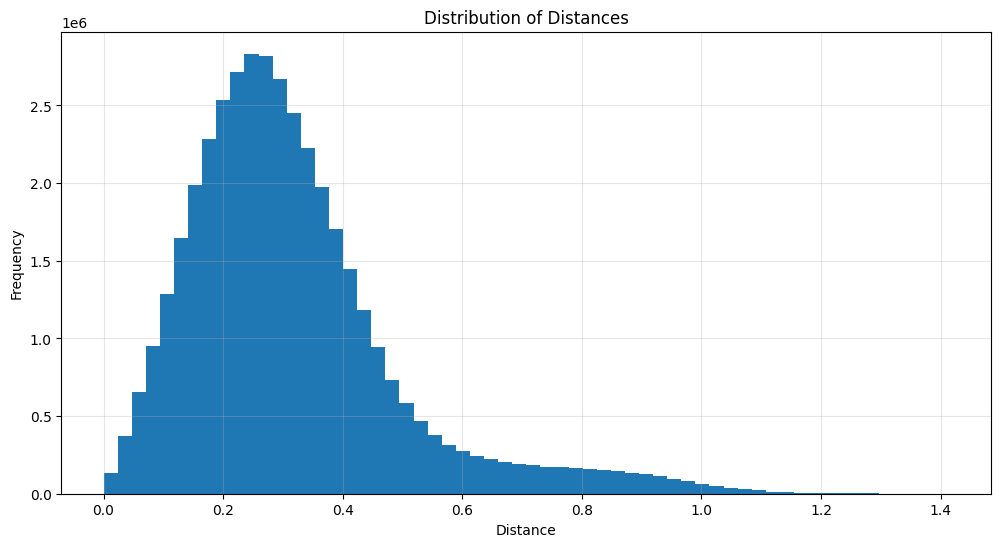

In [14]:
import matplotlib.pyplot as plt

"""
La distribución de distancias parece seguir una lognormal... 
"""

df_dist = pd.read_parquet('graphs/adh_distances.parquet')

# Create histogram with 50 bins
plt.figure(figsize=(12, 6))
df_dist.query('distance < 1e8')['distance'].hist(bins=60)

# Customize the plot
plt.title('Distribution of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

In [15]:
# Salvamos el grafo segmentado
ox.save_graphml(G_segmented, filepath='graphs/adh_segmented.graphml')